# Adaptive Exponential integrate-and-fire (AdEx IF) neuron and synaptic connections


В этом ноутбуке (электронной рабочей тетради) мы научимся задавать в `Brian2` модели AdEX нейронов и синаптические контакты между ними. Настоятельно рекомендуется заглянуть в документацию по `Brian2` и в книгу W.Gerstner et al "Neuronal Dynamics". 

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd # это нам понадобится для чтения csv файлов

In [3]:
# Крупные шрифты в рисунках
rc('xtick', labelsize=16) 
rc('ytick', labelsize=16)
rc('axes',labelsize=16, grid=True)
rc('font',size=16)

In [4]:
from brian2 import *

In [5]:
import input_factory as inpf

## AdEx IF neuron

Итак, модель AdEx:

\begin{align}
C\frac{dv}{dt} &= I_{stim} - g_L(v-E_L) + g_L\Delta T e^{\frac{v-V_{\theta}}{\Delta T}} - u + I_{syn}\\
\tau_u\frac{du}{dt} &= a(v-E_L) - u
\end{align}

Если $v$ превышает пороговое значение $V_{cut}$, то интегрирование системы останавливается, и переменным $v$ и $u$ присваиваются новые значения:
\begin{align}
v &\leftarrow v_{reset}\\
u &\leftarrow u + b\,,
\end{align}
после чего, интегрирование продолжается снова.

Синаптический ток складывается из обобщенного возбуждающего и обобщенного тормозящего токов. При этом увеличения проводимостей у нас будут мгновенны, а затухать по простой экспоненте:
\begin{align}
-I_{syn} &= g_e(v-E_{ex}) + g_i(v-E_{inh})\\
\frac{dg_e}{dt} &= -g_e/\tau_e \\
\frac{dg_i}{dt} &= -g_i/\tau_i
\end{align}

In [6]:
## Parameters that are shared by all neurons

# Neurons
Vth = -50*mV   # rheobase threshold
El = -70*mV     # resting membrane potential
Vcut = 0*mV    # spike detection threshold
deltaT = 2*mV  # spike initiation sharpness
Rin = 500*Mohm  # input resistance of a neuron at rest
gl = 1/Rin



# Synapses
E_e = 0*mV     # Excitatory synaptic reversal potential (AMPA and NMDA receptors)
E_i = -80*mV   # Inhibitory synaptic reversal potential (GABAA receptors)
tau_e = 5*ms   # time scale of excitatory synaptic conductance
tau_i = 10*ms  # time scale of excitatory synaptic conductance



AdEx_equations = Equations('''

dv/dt = (-gl*(v-El) + activation_curr - u + Isyn + Ibias + Iapp)/C : volt 
du/dt = (a*(v-El) - u)/tau_u: amp  # adaptation variable
activation_curr = gl*deltaT*exp((v-Vth)/deltaT) : amp
stim_amp : 1
Ibias : amp
Iapp = stim_amp*input_current(t,i): amp
''')

# Synaptic input
synaptic_equations = Equations("""
Isyn =  - g_e*(v-E_e) - g_i*(v-E_i) : amp
dg_e/dt = -g_e/tau_e : siemens
dg_i/dt = -g_i/tau_i : siemens
""")

Несложно вывести выражения для нульклин. Попробуйте это сделать самостоятельно.

In [7]:
def v_nullcline(v,Ibias=0*pA):
    return Ibias - gl*(v - El) + gl*deltaT*exp((v-Vth)/deltaT)

def u_nullcline(v,pars):
    return pars['a']*(v-El)

Мы будет использовать следующие наборы параметров для разных типов нейронов коры:

In [8]:
adex_params = pd.read_csv('adex_params.csv',index_col='type')
adex_params

,tau_m [ms],a [nS],tau_u [ms],b [pA],Vreset [mV]
type,,,,,
tonic,20.0,0.0,30,60,-55
adapting,200.0,0.0,100,5,-55
init. burst,5.0,0.5,100,7,-51
bursting,5.0,-0.5,100,7,-46
irregular,9.9,-0.5,100,7,-46
transient,10.0,1.0,100,10,-60
delayed,5.0,-1.0,100,10,-60


In [9]:
adex_params.loc['adapting']

tau_m [ms]     200.0
a [nS]           0.0
tau_u [ms]     100.0
b [pA]           5.0
Vreset [mV]    -55.0
Name: adapting, dtype: float64

In [10]:
def convert_table_cell(col_name):
    units = col_name.split(' ')[1][1:-1]

def convert_from_table(row):
    return dict(
        a = float(row['a [nS]'])*nS,
        b = float(row['b [pA]'])*pA,
        tau_u = float(row['tau_u [ms]'])*ms,
        Vreset = float(row['Vreset [mV]'])*mV,
        C = float(row['tau_m [ms]'])*ms*gl,
    )

###  Set up parameters for different behaviour type

In [11]:
tonic_pars = convert_from_table(adex_params.loc['tonic'])

adapting_pars = convert_from_table(adex_params.loc['adapting'])

bursting_pars = convert_from_table(adex_params.loc['bursting'])

initial_burst_pars = convert_from_table(adex_params.loc['init. burst'])

irregular_pars = convert_from_table(adex_params.loc['irregular'])

transient_pars = convert_from_table(adex_params.loc['transient'])

delayed_pars = convert_from_table(adex_params.loc['delayed'])


In [12]:
Rin*tonic_pars['C']

20. * msecond

### Plotting the nullclines

Итак, попробуем разобраться в свойствах возбудимости наших моделей.

Text(0.5, 1.0, 'Nullclines of the bursting AdEx neuron')

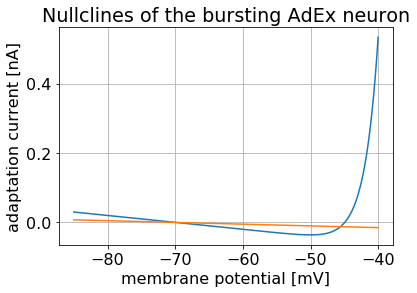

In [13]:
vv = linspace(-85, -40, 200)*mV
plot(vv/mV,v_nullcline(vv)/nA)
#plot(vv/mV, u_nullcline(vv,bursting_pars)/nA)
plot(vv/mV, u_nullcline(vv,bursting_pars)/nA)
xlabel('membrane potential [mV]')
ylabel('adaptation current [nA]')
title('Nullclines of the bursting AdEx neuron')

Если мы не задаем сеть как отдельный объект, нам нужно начинать с команды `start_scope()`. Зададим количество нейронов и создадим группу тонических нейронов. Для того, чтобы наблюдать за переменными модели, нужно подключить к ней мониторы.

In [14]:
start_scope()

Nneurons = 10

defaultclock.dt = 0.1*ms

G = NeuronGroup(Nneurons, AdEx_equations+synaptic_equations,threshold='v>Vcut', reset='v=Vreset; u += b',
                namespace=tonic_pars,
                method='exponential_euler')

G.set_states(dict(v=El,u=0))

G.stim_amp = linspace(0,0.5,Nneurons)
G.stim_amp[1] = 0.065
G.v = -70*mV
M = StateMonitor(G, ['v','u'], record=True)
S = SpikeMonitor(G,)

In [15]:
input_current = inpf.get_step_current(200, 1500, 1*ms, 1.0*nA,Nneurons=Nneurons)

In [16]:
G.stim_amp[1]*nA

65. * pamp

In [17]:
store()

In [18]:
restore()

In [19]:
%time run(2*second)

WARNING    /home/brazhe/opt/anaconda3/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /home/brazhe/.cython/brian_extensions/_cython_magic_afaa46f1a320b579aad18df0bc343b7c.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
 [py.warnings]
WARNING    /home/brazhe/opt/anaconda3/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /home/brazhe/.cython/brian_extensions/_cython_magic_07422f0c0f737042861f82e148d448eb.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
 [py.warnings]


CPU times: user 2.22 s, sys: 43.4 ms, total: 2.27 s
Wall time: 7.35 s


(200, 250)

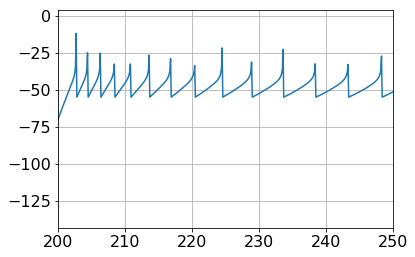

In [20]:
plot(M.t/ms, M.v[-1]/mV)
xlim(200,250)

Мда, из-за остановок и рестарта счета, все спайки оказываются разной амплитуды. К счастью, это несложно исправить.

In [21]:
def beautify_spikes(statemon,spikemon,neuron_id):
    vm = statemon[neuron_id].v[:]
    offset = statemon.t[0]#/defaultclock.dt
    spike_times = spikemon.t[spikemon.i == neuron_id]
    for t in spike_times:
        i = int((t-offset) / defaultclock.dt)
        vm[i] = 20*mV
    return vm

(0, 2000)

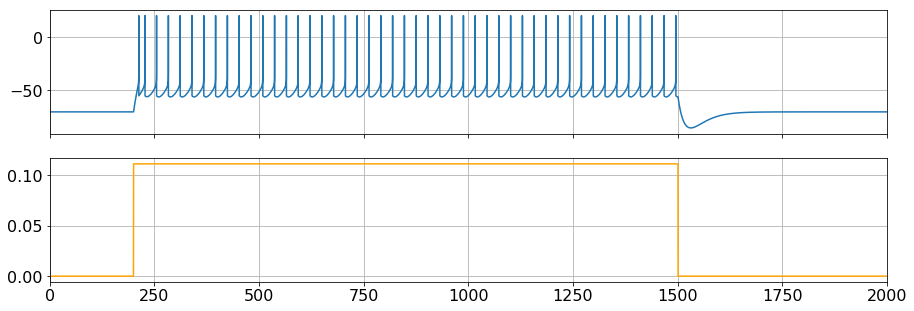

In [22]:
k = 2

f,axs = subplots(2,1,sharex=True, figsize=(15,5))
vx = beautify_spikes(M,S,k)/mV
axs[0].plot(M.t/ms,vx)
axs[1].plot(M.t/ms, G.stim_amp[k]*input_current(M.t,k)/nA,c='orange')
xlim(0,2000)

(200, 300)

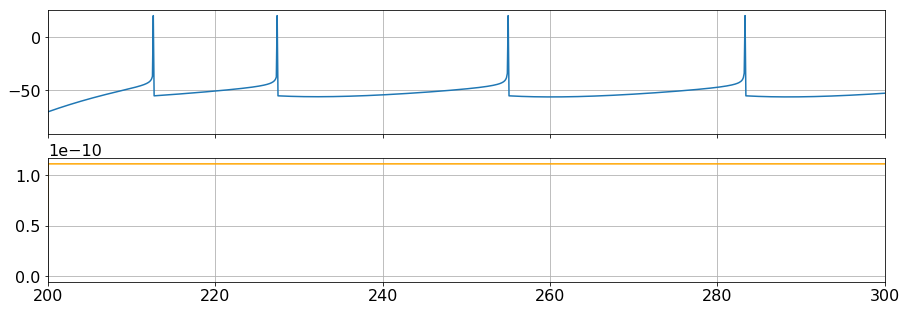

In [23]:
f,axs = subplots(2,1,sharex=True, figsize=(15,5))
vx = beautify_spikes(M,S,k)/mV
axs[0].plot(M.t/ms,vx)
axs[1].plot(M.t/ms, G.stim_amp[k]*input_current(M.t,k),c='orange')
xlim(200,300)

Итак, что же происходит с фазовым портретом при начале стимуляции? 

Text(0.5, 1.0, 'Nullclines and trajectory of the tonic AdEx neuron')

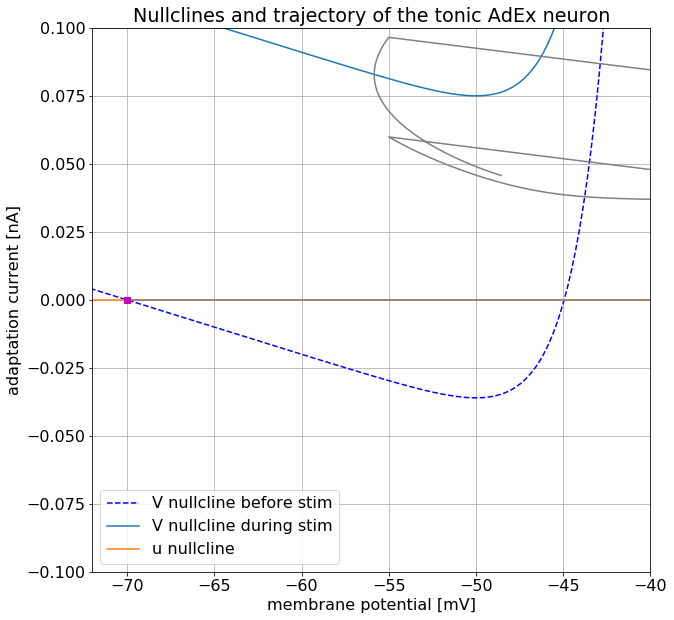

In [24]:
figure(figsize=(10,10))

vv = linspace(-85, -40, 200)*mV

plot(vv/mV,v_nullcline(vv,0)/nA,ls='--',c='blue',label='V nullcline before stim')
plot(vv/mV,v_nullcline(vv,G.stim_amp[k]*nA)/nA,ls='-',label='V nullcline during stim')
plot(vv/mV, u_nullcline(vv,tonic_pars, )/nA,label='u nullcline')

# trajectory
plot(vx[M.t<250*ms],M.u[k][M.t<250*ms]/nA,color='gray')
plot(vx[0],M.u[k][0]/nA,'ms')

axis([-72,-40,-0.1,0.1])
legend()

xlabel('membrane potential [mV]')
ylabel('adaptation current [nA]')
title('Nullclines and trajectory of the tonic AdEx neuron')

### Синаптический вход

Создадим теперь нейрон с псевдореалистичным афферентным входом. Будем считать, что у этого нейрона есть 500 возбуждающих афферентных синапса и 100 тормозящих. Мы не будем напрямую моделировать эти нейроны. Вместо этого, возьмем соответствующее количество пуассоновских стохастических процессов. Они и будут задавать нам пресинаптические события. Пока без пластичности.

In [25]:
start_scope()

Nneurons = 1

defaultclock.dt = 0.1*ms

G = NeuronGroup(Nneurons, AdEx_equations+synaptic_equations,
                threshold='v>Vcut', reset='v=Vreset; u += b',
                namespace=tonic_pars,
                method='exponential_euler')

G.set_states(dict(v=El,u=0))

#G.stim_amp = linspace(0,0.5,Nneurons)
M = StateMonitor(G, ['v','g_e','g_i', 'Isyn'], record=True)
S = SpikeMonitor(G,)

# compensate for small number of synapses by increasing
# their conductance
w_e = 0.05*nS
w_i = 1*nS


<font color=red>
**Exercise:**
 - make and plot recordings of all neuron response types
 - make plots with nullclines and trajectories for one additional response type (any)
             

In [26]:
e_rate = 15*Hz # Mean firing rate of excitatory afferents
i_rate = 3*Hz # Mean firing rate of inhibitory afferents

Ne = 500      # Number of excitatory afferents
Ni = Ne//5    # NUmber of inhibitory afferents  

scale_coef = 1.

Pe = PoissonInput(G, 'g_e', Ne, e_rate, weight=scale_coef*w_e)
Pi = PoissonInput(G, 'g_i', Ni, i_rate, weight=scale_coef*w_i)


In [27]:
%time run(1*second)

WARNING    /home/brazhe/opt/anaconda3/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /home/brazhe/.cython/brian_extensions/_cython_magic_52ba067c6b9364f7d17305a994cea428.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
 [py.warnings]
WARNING    /home/brazhe/opt/anaconda3/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /home/brazhe/.cython/brian_extensions/_cython_magic_dc4fd0f83792c169ff4d0d9df146bf62.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
 [py.warnings]
WARNING    /home/brazhe/opt/anaconda3/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /home/brazhe/.cython/brian_exte

CPU times: user 2.5 s, sys: 63.4 ms, total: 2.56 s
Wall time: 10.4 s


In [28]:
S.num_spikes/10/second

100. * mhertz

Text(0.5, 0, 'время, мс')

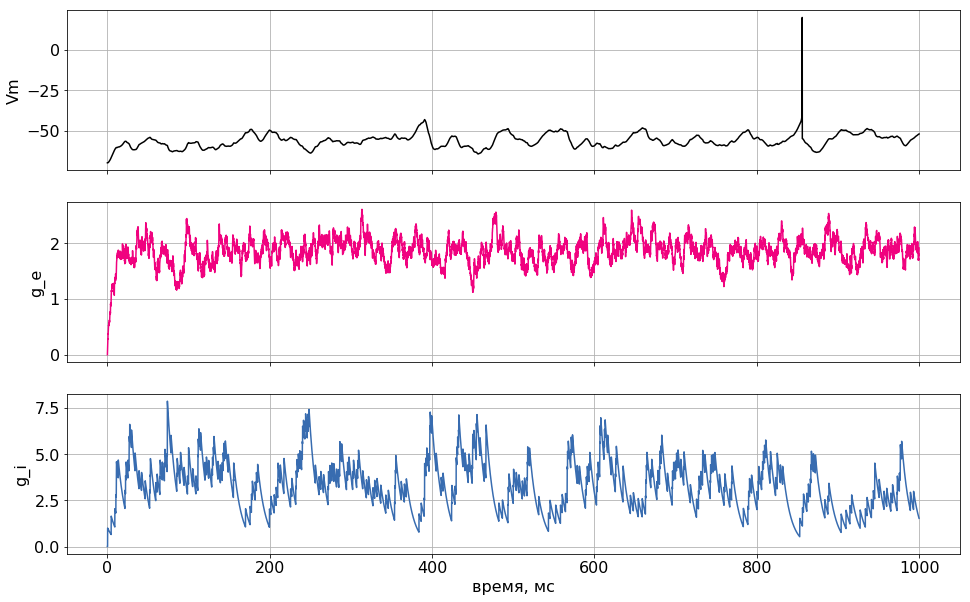

In [29]:
f,axs = subplots(3,1,sharex=True,figsize=(16,10))
axs[0].plot(M.t/ms, beautify_spikes(M,S,0)/mV,c='k')
axs[0].set_ylabel('Vm')
axs[1].plot(M.t/ms, M.g_e[0]/nS, c=mpl.cm.Accent(5))
axs[1].set_ylabel('g_e')
axs[2].plot(M.t/ms, M.g_i[0]/nS, c=mpl.cm.Accent(4))
axs[2].set_ylabel('g_i')
xlabel('время, мс')


## Synaptic connections

### Pair of neurons

Итак, создадим два нейрона и свяжем их синапсами. Один нейрон будет возбуждающий, а второй — тормозный. Добавим модель Tsodyks-Markram для пресинаптической пластичности.

In [30]:
tau_ps = 0.8*second   # facilitation timescale
tau_ns = 1.5*second   # replenishing timescale
p_s0 = 0.6            # ground-state probability of release

plasticity_model = Equations('''
dp_s/dt = (p_s0-p_s)/tau_ps : 1 (event-driven)    # vesicle merge probability
dn_s/dt = (1-n_s)/tau_ns   : 1  (event-driven)    # fraction of resources available
''')

plasticity_action='''
p_s += p_s0*(1-p_s) # facilitation
r_s = p_s*n_s       # probability of release
n_s -= r_s          # depletion
'''

In [31]:
# compensate for small number of synapses by increasing
# their conductance
w_e = 2000*0.05*nS
w_i = 500*1*nS

In [32]:
start_scope()
G = NeuronGroup(2, AdEx_equations+synaptic_equations,
                threshold='v>Vcut', reset='v=Vreset; u += b',
                namespace=adapting_pars,
                method='exponential_euler')
G.Ibias[1] = 0.03*nA
G.set_states(dict(v=El + G.Ibias/gl,u=0*pA))

Нужно создать объекты для хранения синаптических связей между нейронами в сети. То, что происходит с синапсом после прохождения *пресинаптического* спайка записывается в аргумент `on_pre`.

In [33]:
S_exc = Synapses(G,G, model=plasticity_model,on_pre=plasticity_action+'g_e_post += w_e*r_s')
S_inh = Synapses(G,G, model=plasticity_model,on_pre=plasticity_action+'g_i_post += w_i*r_s')

И, наконец, связываем нейроны.

In [34]:
S_exc.connect(i=0,j=1) # don't have much choice when there are only two neurons
S_exc.delay = '10*ms + 0.1*randn()*ms'

S_inh.connect(i=1,j=0)
S_inh.delay = '10*ms'

добавляем мониторы состояний.

In [35]:
#run(20*ms)
M = StateMonitor(G, record=True, variables=True)
S = SpikeMonitor(G)
store()

In [36]:
restore()
G.stim_amp[0] = 0.65 #linspace(1,0,Nneurons)
run(1.5*second)

WARNING    /home/brazhe/opt/anaconda3/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /home/brazhe/.cython/brian_extensions/_cython_magic_97bc17dac331a60796e96842f5e8de7c.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
 [py.warnings]
WARNING    /home/brazhe/opt/anaconda3/lib/python3.6/site-packages/sympy/matrices/matrices.py:2479: SymPyDeprecationWarning: 

Dot product of non row/column vectors has been deprecated since SymPy
1.2. Use * to take matrix products instead. See
https://github.com/sympy/sympy/issues/13815 for more info.

  useinstead="* to take matrix products").warn()
 [py.warnings]
WARNING    /home/brazhe/opt/anaconda3/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /home/brazhe/.cython/brian_extensions/

Text(0.5, 0, 'time [ms]')

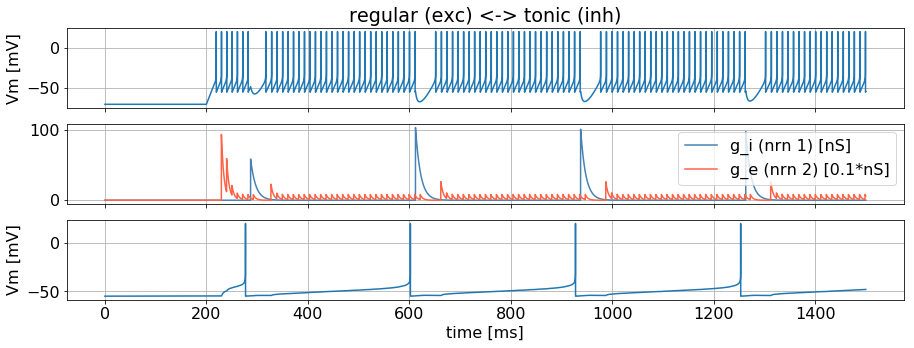

In [37]:
f,axs = subplots(3,1,sharex=True, figsize=(15,5))

axs[0].plot(M.t/ms, beautify_spikes(M,S,0)/mV)
axs[0].set_ylabel('Vm [mV]')

axs[1].plot(M.t/ms, M.g_i[0]/nS, c='steelblue', label='g_i (nrn 1) [nS]')
axs[1].plot(M.t/ms, 10*M.g_e[1]/nsiemens, c='tomato', label='g_e (nrn 2) [0.1*nS]')
axs[1].legend()

axs[2].plot(M.t/ms, beautify_spikes(M,S,1)/mV)
axs[2].set_ylabel('Vm [mV]')

axs[0].set_title('regular (exc) <-> tonic (inh)')
xlabel('time [ms]')
#xlim(600,800)

<font color=red>
**Exercise:**
 - Try changing characteristic times for depletion and describe and illustrate what happens
 - Try connecting neurons with different response types and record patterns of dynamics
             

### Small network

Создадим теперь сеть побольше — из 10 возбуждающих и 1 тормозного нейрона.

In [38]:
# compensate for small number of synapses by increasing
# their conductance
w_e = 500*0.05*nS
w_i = 500*1*nS

In [39]:
start_scope()

seed(4022)

Nexc = 10

G1 = NeuronGroup(Nexc, AdEx_equations+synaptic_equations,
                 threshold='v>Vcut', reset='v=Vreset; u += b',
                namespace=adapting_pars,
                method='exponential_euler')

G1.Ibias = '25*pA + randn()*5*pA'
G1.set_states(dict(v=El + G1.Ibias/gl, u=0*pA))

G2 = NeuronGroup(1, AdEx_equations+synaptic_equations,
                 threshold='v>Vcut', reset='v=Vreset; u += b',
                namespace=tonic_pars,
                method='exponential_euler')
G2.set_states(dict(v=El, u=0*pA))

In [40]:
#R = Spikeinput_current = inpf.get_step_current(200, 800, 1*ms, 1.0*nA,Nneurons=Nneurons)neratorGroup()

In [41]:
input_current = inpf.get_step_current(200, 2000, 1*ms, 1.0*nA,Nneurons=Nexc)

Нам будут нужны синапсы между возбуждающими нейронами, от возбуждающих к тормозному и наоборот.

In [42]:
S_exc = Synapses(G1,G2, model=plasticity_model,on_pre=plasticity_action+'g_e_post += w_e*r_s')
S_exc2 = Synapses(G1,G1, model=plasticity_model,on_pre=plasticity_action+'g_e_post += w_e*r_s')

S_inh = Synapses(G2,G1, model=plasticity_model,on_pre=plasticity_action+'g_i_post += w_i*r_s')

In [43]:
S_exc.connect(p=0.85) # возбуждающий нейрон с вероятностью 0.85 образует синапс на тормозном
S_exc2.connect(p=0.85,condition='i!=j')     # два произвольно взятых нейрона соединены с вероятностью 0.85
# Сигнал не может распространяться мгновенно, и в синаптических связях будут случайные задержки
S_exc.delay = 'clip(10*ms + 0.1*randn()*ms,0,100*ms)'  

S_inh.connect(p=1)
S_inh.delay = 'clip(10*ms + 0.1*randn()*ms,0,100*ms)'

In [44]:
#run(20*ms)
M1 = StateMonitor(G1, record=True, variables=True)
M2 = StateMonitor(G2, record=True, variables=True)

S1 = SpikeMonitor(G1)
S2 = SpikeMonitor(G2)

store()

In [45]:
restore()
S_inh.active=True
G1.stim_amp = 0.05 #linspace(1,0,Nneurons)
G2.Ibias = 0.01*nA

In [46]:
%time  run(3*second)

WARNING    /home/brazhe/opt/anaconda3/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /home/brazhe/.cython/brian_extensions/_cython_magic_df04577bbba25460cc6d7cf9a0fab5ab.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
 [py.warnings]
WARNING    /home/brazhe/opt/anaconda3/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /home/brazhe/.cython/brian_extensions/_cython_magic_80cdbcdff57949eee0f55ffd711e9edb.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
 [py.warnings]
WARNING    /home/brazhe/opt/anaconda3/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /home/brazhe/.cython/brian_exte

CPU times: user 9.87 s, sys: 223 ms, total: 10.1 s
Wall time: 30.7 s


Text(0.5, 0, 'time [ms]')

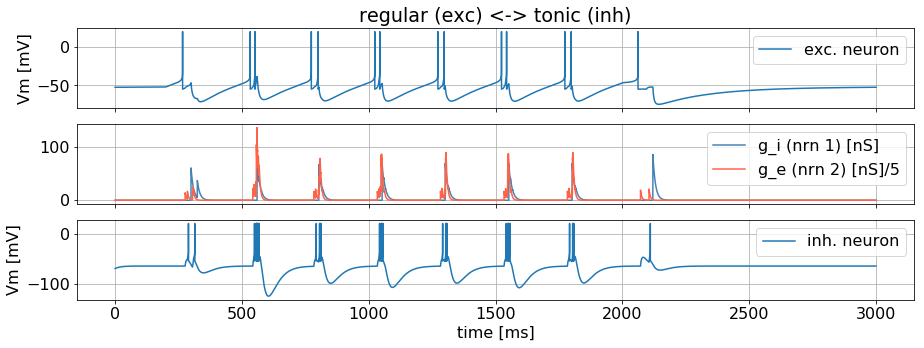

In [47]:
f,axs = subplots(3,1,sharex=True, figsize=(15,5))

axs[0].plot(M1.t/ms, beautify_spikes(M1,S1,0)/mV,label='exc. neuron')
axs[0].set_ylabel('Vm [mV]')
axs[0].legend()

axs[1].plot(M1.t/ms, M1.g_i[1]/nS, c='steelblue', label='g_i (nrn 1) [nS]')
axs[1].plot(M2.t/ms, 5*M2.g_e[0]/nS, c='tomato', label='g_e (nrn 2) [nS]/5')
axs[1].legend()

axs[2].plot(M2.t/ms, beautify_spikes(M2,S2,0)/mV,label='inh. neuron')
axs[2].set_ylabel('Vm [mV]')
axs[2].legend()

axs[0].set_title('regular (exc) <-> tonic (inh)')
xlabel('time [ms]')
#xlim(600,800)

In [48]:
def raster_spikes(spikemon,c='r',offset=0):
    plot(spikemon.t/ms, spikemon.i+offset,'|',c=c)

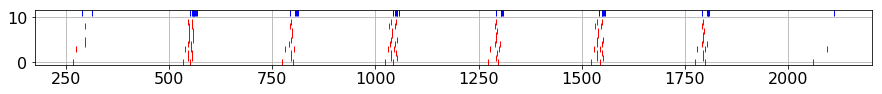

In [49]:
figure(figsize=(15,1))
raster_spikes(S1)
raster_spikes(S2,c='b',offset=Nexc+1)

**Exercise:**
 - [ ] Compare network activity with and without inhibition (set `S_inh.active` to `False`). Describe changes.
 - [ ] Try using different kinds of pre- and post-synaptic neurons. Can you find interesting patterns of behaviour?
 - [ ] `*` [hard] Connect a SpikeGenerator object to a subset of excitatory neurons instead of step current
             